## Declaration of Authorship {.unnumbered .unlisted}

We, \[DeskB\], confirm that the work presented in this assessment is our own. Where information has been derived from other sources, we confirm that this has been indicated in the work. Where a Large Language Model such as ChatGPT has been used we confirm that we have made its contribution to the final submission clear.

Date: 11th December 2023

Student Numbers: 20017359 23032922 23081403 23103585 23130397

## Brief Group Reflection

| What Went Well | What Was Challenging |
|----------------|----------------------|
| A              | B                    |
| C              | D                    |

## Priorities for Feedback

Are there any areas on which you would appreciate more detailed feedback if we're able to offer it?



```{=html}
<style type="text/css">
.duedate {
  border: dotted 2px red; 
  background-color: rgb(255, 235, 235);
  height: 50px;
  line-height: 50px;
  margin-left: 40px;
  margin-right: 40px
  margin-top: 10px;
  margin-bottom: 10px;
  color: rgb(150,100,100);
  text-align: center;
}
</style>
```

{{< pagebreak >}}





# Response to Questions


**Import all packages**

In [57]:
import os
import spacy
import pandas as pd
import numpy as np
import geopandas as gpd
import re
import math
import string
import unicodedata
import gensim
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from joblib import dump
from joblib import load
import contextily as ctx
import urllib.request

from scipy.spatial import cKDTree
from scipy.spatial.distance import cdist

from shapely.geometry import Point

from sklearn.preprocessing import OneHotEncoder  # We don't use this but I point out where you *could*
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC


from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk import ngrams, FreqDist

from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.matutils import Sparse2Corpus
from gensim.matutils import corpus2dense
from gensim.models import tfidfmodel
from gensim.models import Word2Vec
from gensim.models import TfidfModel
from gensim.models import KeyedVectors
from gensim.models.ldamodel import LdaModel

from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS

nltk.download('stopwords')
stopword_list = set(stopwords.words('english'))

# Import everthing from textual/__init__.py
# Including bunch of tools and functions we could use for NLP 
from textual import *

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SBH\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
# Some Configuration allowing us to output Markdown (like this cell) instead of plain text
from IPython.display import display_markdown

def as_markdown(head='', body='Some body text'):
    if head != '':
        display_markdown(f"##### {head}\n\n>{body}\n", raw=True)
    else:
        display_markdown(f">{body}\n", raw=True)

as_markdown('Result!', "Here's my output...")

##### Result!

>Here's my output...


**Loading the Data**

In [18]:
# Download and read the csv file remotely from url
host = 'http://data.insideairbnb.com'
path = 'united-kingdom/england/london/2023-09-06/data'
file = 'listings.csv.gz'
url  = f'{host}/{path}/{file}'

# Save csv file
if os.path.exists(file):
  Airbnb_Listing = pd.read_csv(file, compression='gzip', low_memory=False)
else: 
  Airbnb_Listing = pd.read_csv(url, compression='gzip', low_memory=False)
  Airbnb_Listing.to_csv(file)

# Download and read the gpkg file remotel from url
host = 'https://data.london.gov.uk'
path = 'download/london_boroughs/9502cdec-5df0-46e3-8aa1-2b5c5233a31f'
file = 'London_Boroughs.gpkg'
url  = f'{host}/{path}/{file}'

# Save gkpg file
if os.path.exists(file):
  London_boroughs = gpd.read_file(file, compression='gzip', low_memory=False)
else: 
  London_boroughs = gpd.read_file(url, compression='gzip', low_memory=False)
  London_boroughs.to_file(file, driver='GPKG')


## 1. Who collected the data? ( 2 points; Answer due Week 7 )

::: 1.[\*listings.csv](http://data.insideairbnb.com/united-kingdom/england/london/2023-09-06/data/listings.csv.gz) : This dataset was created by automatically scraping public information from Airbnb's Website. Murray Cox was one of the main founder and technicians of this mission driven project that aims to provide data and advocacy about Airbnb's impact on residential communities. [\[1\]]((http://insideairbnb.com/about))

2.[\*London_Boroughs.gpkg](https://data.london.gov.uk/download/london_boroughs/9502cdec-5df0-46e3-8aa1-2b5c5233a31f/London_Boroughs.gpkg) and [London-wards-2018](https://data.london.gov.uk/download/statistical-gis-boundary-files-london/08d31995-dd27-423c-a987-57fe8e952990/London-wards-2018.zip) : This dataset is an extract from [Ordnance Survey](https://www.ordnancesurvey.co.uk/) Boundary-Line product which is a specialist 1:10 000 scale boundaries dataset.

:::

An inline citation: As discussed on @insideairbnb, there are many...

A parenthetical citation: There are many ways to research Airbnb [see, for example, @insideairbnb]...


## 2. Why did they collect it? ( 4 points; Answer due Week 7 )

:::

1.[\*listings.csv](http://data.insideairbnb.com/united-kingdom/england/london/2023-09-06/data/listings.csv.gz) : Inside Airbnb is a mission driven project that provides data and advocacy about Airbnb's impact on residential communities. We work towards a vision where communities are empowered with data and information to understand, decide and control the role of renting residential homes to tourists.

2.[\*London_Boroughs.gpkg](https://data.london.gov.uk/download/london_boroughs/9502cdec-5df0-46e3-8aa1-2b5c5233a31f/London_Boroughs.gpkg) : With a long history and evolving from . The Ordnance Survey aims to help governments make smarter decisions that ensure our safety and security, they also show businesses how to gain a location data edge and we help everyone experience the benefits of the world outside. Under the [Public Sector Geospatial Agreement](https://www.ordnancesurvey.co.uk/customers/public-sector/public-sector-geospatial-agreement) (PSGA), Ordnance Survey (OS) provides Great Britain' national mapping services. OS creates, maintains and provides access to consistent, definitive and authoritative location data of Great Britain, aiming to help organisations to maximise the use, value and benefit of the data for the national interest and the public good. :::


**Size of Data**

In [19]:
print(f"Data frame is {Airbnb_Listing.shape[0]:,} x {Airbnb_Listing.shape[1]:,}")
#print(Airbnb_Listing.columns)

Data frame is 87,946 x 75


## 3. How was the data collected? ( 5 points; Answer due Week 8 )

::: 1.[\*listings.csv](http://data.insideairbnb.com/united-kingdom/england/london/2023-09-06/data/listings.csv.gz) : Inside Airbnb collects its data primarily by scraping information from the Airbnb website. This process involves the following steps:

**i.Web Scraping**: Inside Airbnb uses automated scripts to systematically browse and extract data from Airbnb's listings. These scripts navigate the website just like a human user would, but they do it much faster and on a larger scale.

**ii.Data Extraction**: Information about each listing, such as location, price, availability, number of bedrooms, reviews, and host details, is extracted and compiled.

**iii.Data Aggregation**: The collected data is then aggregated into a database. This database is organized to make it easier to analyze trends, patterns, and insights related to Airbnb's offerings in various cities and regions.

**iv.Regular Updates**: The scraping process is repeated periodically to keep the database current, capturing new listings and updates to existing ones.

**v.Public Accessibility**: The aggregated data is often made available to the public through the Inside Airbnb website, enabling researchers, policymakers, and the general public to analyze Airbnb's impact on housing markets and communities. It's important to note that web scraping practices, like those used by Inside Airbnb, may face legal and ethical considerations depending on the website's terms of service and regional laws regarding data privacy and usage.

2.[\*London_Boroughs.gpkg](https://data.london.gov.uk/download/london_boroughs/9502cdec-5df0-46e3-8aa1-2b5c5233a31f/London_Boroughs.gpkg) : "Boundary-Line for England and Wales was initially digitised from Ordnance Survey's boundary record sheets at 1:10 000 scale (or, in some cases, at larger scales). The Government Statistical Service (GSS) codes are supplied by the Office for National Statistics and General Register Office for Scotland(GROS). GIS software provides the functionality to store, manage and manipulate this digital map data. The properties of the data make it suitable as a key base for users wishing to develop applications. BoundaryLine is also suitable for use within other digital mapping systems. It's coordinated on the National Grid which allows for the easy superimposition of other data. :::


## 4. How does the method of collection impact the completeness and/or accuracy of its representation of the process it seeks to study, and what wider issues does this raise?

::: duedate
( 11 points; Answer due Week 9 )
:::

## 5. What ethical considerations does the use of this data raise?

::: duedate
( 18 points; Answer due {{< var assess.group-date >}} )
:::

## 6. With reference to the data (*i.e.* using numbers, figures, maps, and descriptive statistics), what does an analysis of Hosts and Listing types suggest about the nature of Airbnb lets in London?

::: duedate
( 15 points; Answer due {{< var assess.group-date >}} )
:::

**数据基础处理**

**Read the normed csvfile**

In [20]:
#Read the normed csv
Airbnb_Listing = pd.read_csv("./Data/Airbnb_Listing_norm.csv")

In [24]:
# Select the Corpus
corpus = Airbnb_Listing['description_norm'].fillna(' ').values


**向stopwords中加入额外不想要的词**

In [22]:
stopwords_extra = ['would','able']

# Latent Dirchlet Allocation 来处理'description'列

In [25]:
# 读取不同主题的coherence值,csv文件
LDA_topic_coherence_frame = pd.read_csv("./Data/coherence_values.csv")

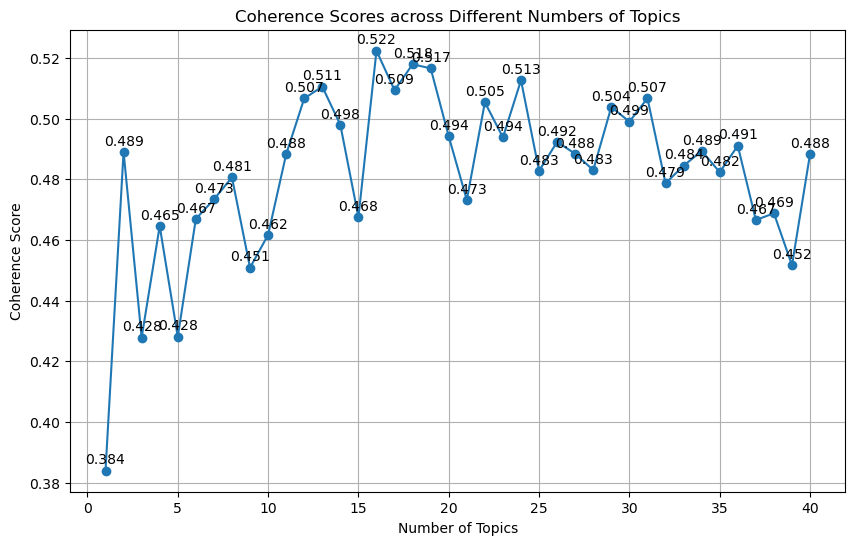

In [26]:
# 主题数量
num_topics = len(LDA_topic_coherence_frame)
# 绘制折线图
plt.figure(figsize=(10, 6))
plt.plot(LDA_topic_coherence_frame['Topic_Num'], LDA_topic_coherence_frame['Coherence_Score'], marker='o')
plt.title('Coherence Scores across Different Numbers of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.grid(True)
# 为每个数据点添加标注
for x, y in zip(LDA_topic_coherence_frame['Topic_Num'], LDA_topic_coherence_frame['Coherence_Score']):
    plt.annotate(f'{y:.3f}',  # 这里是要显示的文本，即y值
                 (x, y),  # 这是要标注的点的坐标
                 textcoords="offset points",  # 指定标注的位置方式
                 xytext=(0,5),  # 指定标注文本的偏移量
                 ha='center')  # 水平居中对齐文本
plt.show()

读取先前保存的LDA 模型生成主题结果csv文件

In [27]:
# 读取先前保存的LDA 模型生成主题结果
LDA_topics_and_words_frame = pd.read_csv(os.path.join("Data","lda_topics_and_words.csv"))

读取每个房源的主题占比csv文件

In [28]:
# 读取每个房源的主题占比csv文件
listing_lda_topic = pd.read_csv(os.path.join("Data","listing_lda_topic.csv"))

# word2vec模型处理amenities列

**Word 2 Vec**

**读取训练后的SVM模型**

In [29]:
svm_classifier = load('svm_classfier_model.joblib')

# 可视化

分析得到的主题，并根据需要进行可视化。

**加入地理信息元素绘图**

In [44]:
Airbnb_Listing_origin = pd.read_csv("./Data/Data_InsideAirbnb/listings.csv.gz")

C:\Users\SBH\AppData\Local\Temp\ipykernel_916\3813638556.py:1: DtypeWarning: Columns (68) have mixed types. Specify dtype option on import or set low_memory=False.
  Airbnb_Listing_origin = pd.read_csv("./Data/Data_InsideAirbnb/listings.csv.gz")


In [45]:
# 每个listing的收入与average收入相比
if Airbnb_Listing_origin['price'].dtype == 'object':
    Airbnb_Listing_origin['price'] = Airbnb_Listing_origin['price'].str.replace('$', '').str.replace(',', '').astype(float)
Airbnb_Listing['sum_income'] = Airbnb_Listing_origin['minimum_nights']*2.7*Airbnb_Listing_origin['number_of_reviews_ltm']*Airbnb_Listing_origin['price']

average_income_forlisting = Airbnb_Listing['sum_income'].mean()
average_income_forlisting

7194.986408705343

In [46]:
Airbnb_Listing['profitable'] = (Airbnb_Listing['sum_income'] >= average_income_forlisting).astype(int)

In [75]:
# Transfer pandas dataframe (Airbnb_listing.csv) to geopandas geodataframe
# By using the coordinates ()

# Converting to GeoDataframe
gdf_listing = gpd.GeoDataFrame(Airbnb_Listing, geometry=gpd.points_from_xy(Airbnb_Listing.longitude, Airbnb_Listing.latitude))

# Set the CRS
gdf_listing.set_crs("EPSG:4326", inplace=True)  # (EPSG:4326)

print("Converting successful")

# Drop NAs of columns ['description','amenities']
gdf_listing = gdf_listing.dropna(subset=['description','amenities'])
print(f"Now gdf has {gdf_listing.shape[0]:,} rows and {gdf_listing.shape[1]:,} columns.")

Converting successful
Now gdf has 86,679 rows and 23 columns.


In [76]:
gdf_listing.columns

Index(['Unnamed: 0', 'id', 'description', 'neighbourhood_cleansed', 'latitude',
       'longitude', 'room_type', 'amenities', 'price', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month', 'description_norm',
       'amenities_norm', 'sum_income', 'profitable', 'geometry'],
      dtype='object')

定义IDW插值函数

In [61]:
# IDW插值函数

def idw_interpolation(x, y, z, xi, yi, k=3):
    tree = cKDTree(np.vstack((x, y)).T)
    distances, locations = tree.query(np.vstack((xi.flatten(), yi.flatten())).T, k=k)
    weights = 1 / distances
    weights /= weights.sum(axis=1)[:, None]
    zi = np.sum(weights * z[locations], axis=1)
    return zi.reshape(xi.shape)

In [ ]:
"""
# 加载数据
coordinates = gdf_listing[['geometry']].copy()
values = gdf_listing['sum_income'].values

# 提取X和Y坐标
x = coordinates.geometry.x
y = coordinates.geometry.y

# 创建插值网格
x_min, y_min, x_max, y_max = coordinates.total_bounds
xi, yi = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]  # 100x100网格
xi, yi = xi.flatten(), yi.flatten()

# 进行IDW插值
zi = idw_interpolation(np.vstack([x, y]).T, values, xi, yi)

# 创建插值后的GeoDataFrame
gdf_interpolated = gpd.GeoDataFrame({'Z': zi}, 
                                    geometry=gpd.points_from_xy(xyi[:, 0], xyi[:, 1]))

# 绘制插值结果
fig, ax = plt.subplots(figsize=(10, 10))
gdf_interpolated.plot(column='Z', ax=ax, alpha=0.5, legend=True,
                      cmap='viridis', markersize=5)
                      """

c:\Users\SBH\anaconda3\Lib\site-packages\contextily\tile.py:614: UserWarning: The inferred zoom level of 27 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


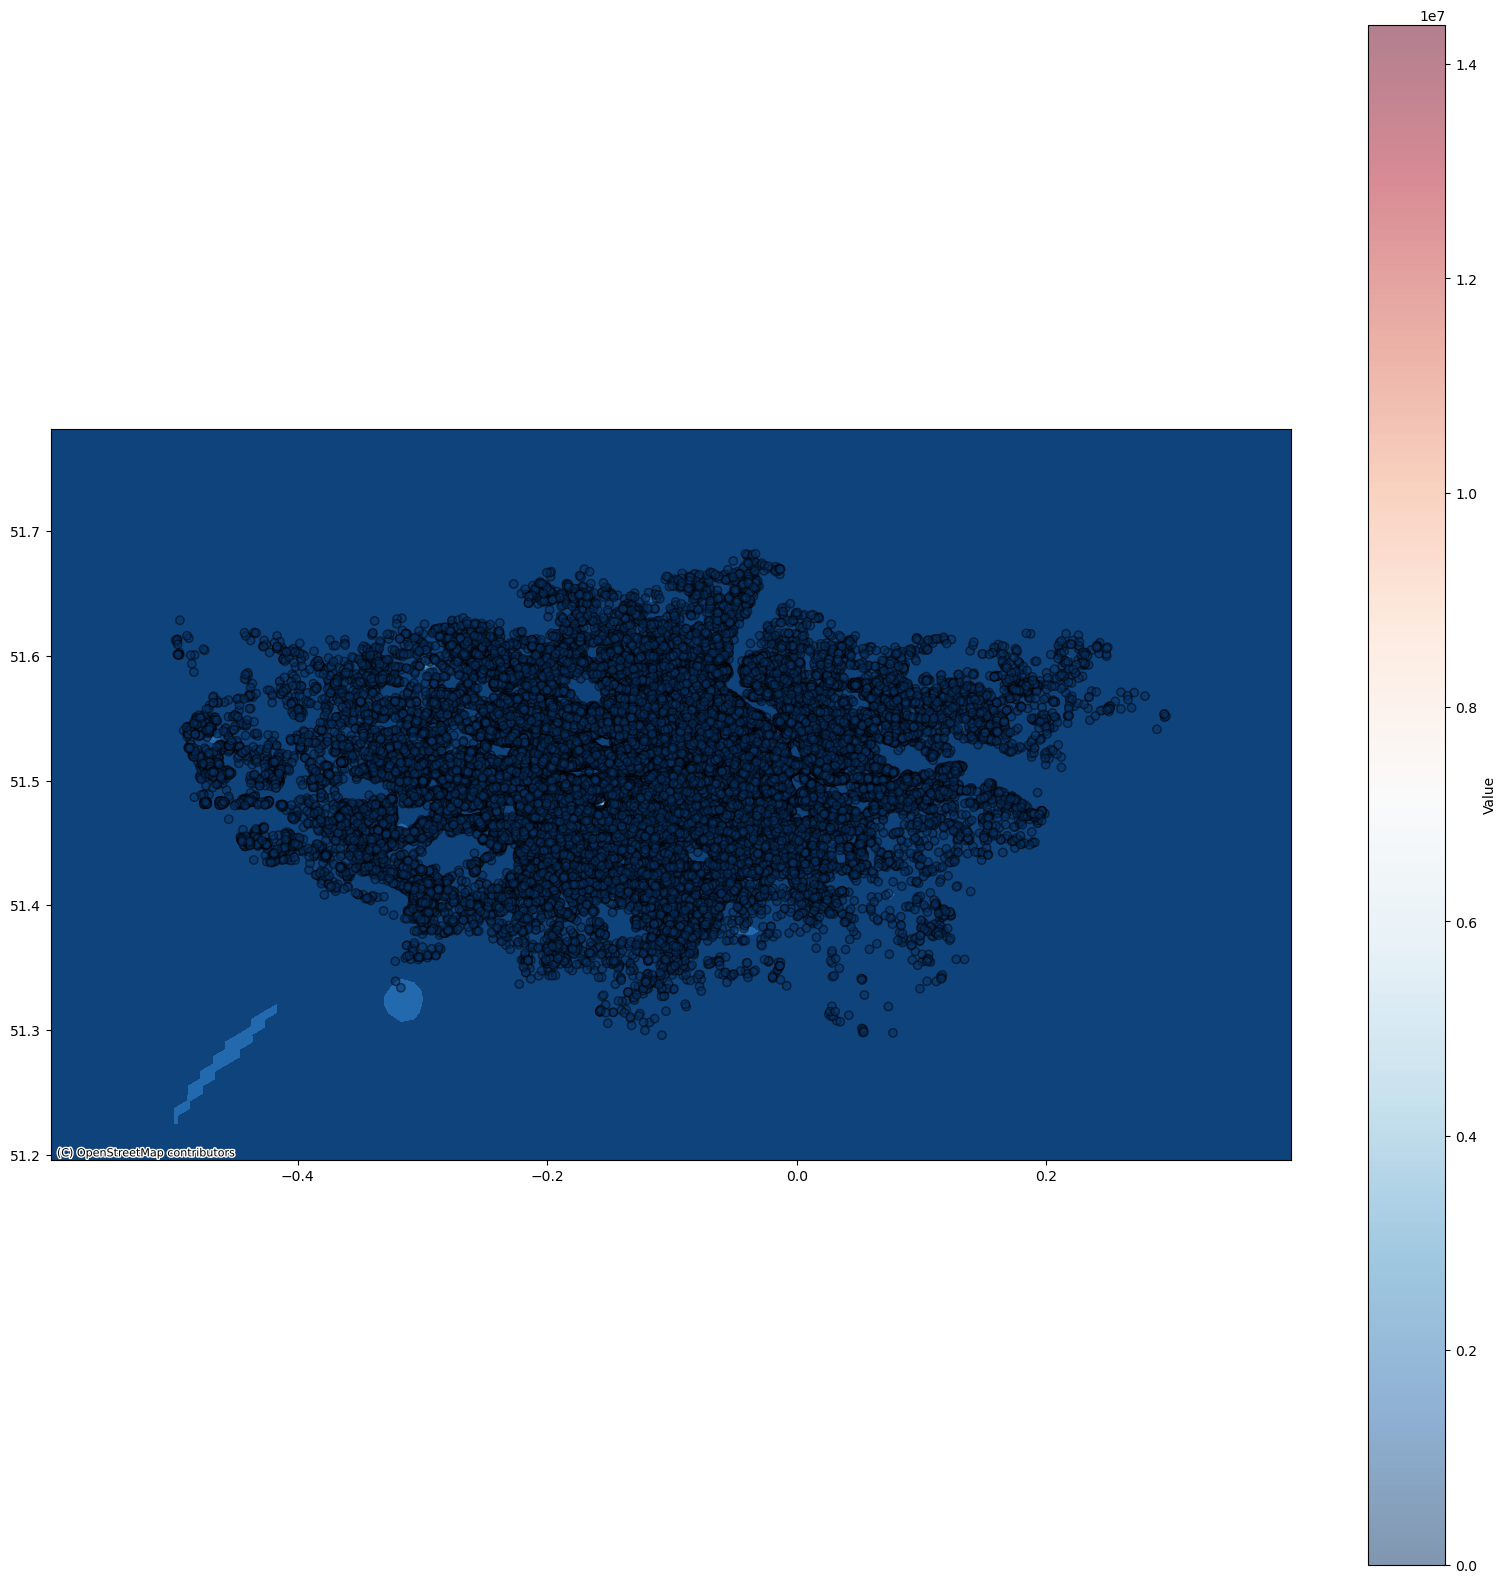

In [74]:
# 创建网格
x = np.linspace(Airbnb_Listing.longitude.min()-0.1, Airbnb_Listing.longitude.max()+0.1, 100)
y = np.linspace(Airbnb_Listing.latitude.min()-0.1, Airbnb_Listing.latitude.max()+0.1, 100)
xx, yy = np.meshgrid(x, y)

z_array = Airbnb_Listing.sum_income.to_numpy()

zi = idw_interpolation(Airbnb_Listing.longitude, Airbnb_Listing.latitude, z_array, xx, yy)


fig, ax = plt.subplots(figsize=(20, 20))


plt.contourf(xx, yy, zi, levels=14, cmap="RdBu_r")
plt.scatter(Airbnb_Listing.longitude, Airbnb_Listing.latitude, c=z_array, cmap="RdBu_r", edgecolor="black",alpha=0.5)
plt.colorbar(label='Value')


# 添加底图
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.show()

# 保存地图
# fig.savefig('london_housing_price_map.png')

## 7. Drawing on your previous answers, and supporting your response with evidence (e.g. figures, maps, and statistical analysis/models), how *could* this data set be used to inform the regulation of Short-Term Lets (STL) in London?

::: duedate
( 45 points; Answer due {{< var assess.group-date >}} )
:::

## Sustainable Authorship Tools

Your QMD file should automatically download your BibTeX file. We will then re-run the QMD file to generate the output successfully.

Written in Markdown and generated from [Quarto](https://quarto.org/). Fonts used: [Spectral](https://fonts.google.com/specimen/Spectral) (mainfont), [Roboto](https://fonts.google.com/specimen/Roboto) ([sansfont]{style="font-family:Sans-Serif;"}) and [JetBrains Mono](https://fonts.google.com/specimen/JetBrains%20Mono) (`monofont`).

## References